# **Lasso regression also known as L1 Regularization: PySpark MLlib on Waves Data**




In [ ]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=7964bfb14f79faf36e88ccef1cf4f837238cf25638206d4b1a8f3333810ed7d9
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


# **Step 1:** Import the required libraries and initialize SparkSession.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LassoRegression") \
                    .getOrCreate()


# **Step 2:** Load and preprocess the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Description

dataset: https://drive.google.com/file/d/1Dy8s4adX6JKHbdfxILrwJ9oCVd9up1UE/view?usp=sharing

The dataset contains measurements related to ocean wave conditions and atmospheric parameters.

| Feature  | Description                                       |
|----------|--------------------------------------------------|
| hh       | Hour of observation                               |
| WDIR     | Wind direction (degrees)                         |
| WSPD     | Wind speed (knots or meters per second)         |
| GST      | Gust speed (maximum wind speed in knots)        |
| DPD      | Dominant period of waves (seconds)              |
| APD      | Average period of waves (seconds)               |
| MWD      | Mean wind direction (degrees)                    |
| PRES     | Atmospheric pressure (millibars)                |
| ATMP     | Air temperature (degrees Celsius or Fahrenheit)  |
| WTMP     | Water temperature (degrees Celsius or Fahrenheit)|
| DEWP     | Dew point temperature (degrees Celsius)          |
| WVHT     | Wave height (meters)                             |


In [ ]:
# Load the data from a CSV file
df = spark.read.csv("/content/drive/MyDrive/waves.csv", header=True, inferSchema=True)

# get familiar with data
df.show()

# more info
print(df.count())

+---+----+----+---+----+----+---+------+----+----+----+----+
| hh|WDIR|WSPD|GST| DPD| APD|MWD|  PRES|ATMP|WTMP|DEWP|WVHT|
+---+----+----+---+----+----+---+------+----+----+----+----+
|  1|  23| 3.0|3.6|4.17|3.33|349|1019.1| 4.7| 5.1| 4.2|0.39|
|  2|  30| 2.9|3.3|5.26|4.21|358|1018.8| 4.6| 4.8| 4.1|0.65|
|  3| 360| 2.2|2.5|5.88|4.79| 11|1018.3| 4.6| 4.7| 4.2| 0.9|
|  4| 355| 2.5|3.1|5.88|4.95| 23|1018.1| 4.6| 4.6| 4.2|0.91|
|  5| 355| 3.5|4.5|6.25|4.98| 26|1018.3| 4.5| 4.6| 4.0|0.88|
|  6|  25| 2.6|3.2|6.25|5.07| 17|1017.7| 4.4| 4.6| 4.0|0.87|
|  7|  32| 1.7|2.3|6.67|4.76| 17|1017.4| 4.5| 4.6| 4.2| 0.8|
|  8| 349| 1.3|1.6|6.67| 4.8| 29|1017.1| 4.6| 4.6| 4.3|0.75|
|  9|  25| 2.3|2.6|6.25|4.98| 17|1017.2| 4.8| 4.6| 4.3|0.83|
| 10|  51| 3.4|3.7|6.25|4.77|  6|1017.1| 5.7| 4.6| 4.7|0.69|
| 11|  53| 3.7|4.1|5.26|4.48|358|1017.5| 5.7| 4.6| 4.8|0.59|
| 12|  57| 3.4|3.9|5.88| 4.7|358|1018.0| 5.7| 4.7| 4.8|0.61|
| 13|  65| 3.5|3.9|5.88|4.59|350|1017.8| 5.7| 4.7| 5.0|0.55|
| 14|  85| 3.3|3.8|5.88|

In [ ]:
df.printSchema()

root
 |-- hh: integer (nullable = true)
 |-- WDIR: integer (nullable = true)
 |-- WSPD: double (nullable = true)
 |-- GST: double (nullable = true)
 |-- DPD: double (nullable = true)
 |-- APD: double (nullable = true)
 |-- MWD: integer (nullable = true)
 |-- PRES: double (nullable = true)
 |-- ATMP: double (nullable = true)
 |-- WTMP: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- WVHT: double (nullable = true)



# Basic Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Analysis

In [ ]:
numeric_columns = ['WSPD', 'GST', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'WVHT']

correlations = {}
for col1 in numeric_columns:
    for col2 in numeric_columns:
        if col1 != col2:
            corr = df.stat.corr(col1, col2)
            correlations[f"{col1}_{col2}"] = corr
print(correlations)


{'WSPD_GST': 0.9869375504273807, 'WSPD_DPD': 0.26577328561018404, 'WSPD_APD': 0.34274069115057443, 'WSPD_MWD': -0.07460426840032279, 'WSPD_PRES': -0.10264930021107165, 'WSPD_ATMP': 0.11091051008195232, 'WSPD_WTMP': 0.12943485608285765, 'WSPD_DEWP': 0.066140471218226, 'WSPD_WVHT': 0.6768042394284911, 'GST_WSPD': 0.9869375504273808, 'GST_DPD': 0.28288535546756516, 'GST_APD': 0.3625899303974412, 'GST_MWD': -0.06511673200169893, 'GST_PRES': -0.08448996376946871, 'GST_ATMP': 0.10574441546823068, 'GST_WTMP': 0.1362229959384705, 'GST_DEWP': 0.05099116563534652, 'GST_WVHT': 0.691531113257056, 'DPD_WSPD': 0.26577328561018404, 'DPD_GST': 0.2828853554675651, 'DPD_APD': 0.908203004758687, 'DPD_MWD': -0.1913777473214723, 'DPD_PRES': 0.09068233832561919, 'DPD_ATMP': -0.16394810380478075, 'DPD_WTMP': -0.037410867723457746, 'DPD_DEWP': -0.23298533278632358, 'DPD_WVHT': 0.7355676135525677, 'APD_WSPD': 0.34274069115057443, 'APD_GST': 0.36258993039744114, 'APD_DPD': 0.908203004758687, 'APD_MWD': -0.20064

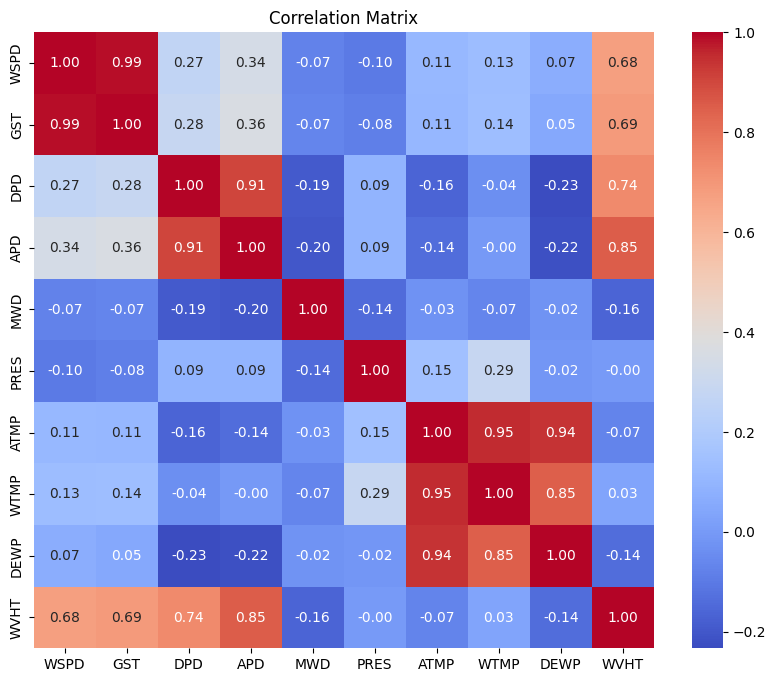

In [ ]:
# Collect data into a pandas DataFrame for correlation visualization
pandas_df = df.select(numeric_columns).toPandas()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pandas_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# **Step 3**: Data Preparation for data modelling

# VectorAssembler

In [ ]:
#Combine features into a single vector col

assembler = VectorAssembler(inputCols=["hh", "WDIR", "WSPD", "GST", "DPD", "APD", "MWD", "PRES", "ATMP", "WTMP", "DEWP"],
                            outputCol="allfeatures")
data = assembler.transform(df)
data = data.select("allfeatures", "WVHT")
data.show(5)

+--------------------+----+
|         allfeatures|WVHT|
+--------------------+----+
|[1.0,23.0,3.0,3.6...|0.39|
|[2.0,30.0,2.9,3.3...|0.65|
|[3.0,360.0,2.2,2....| 0.9|
|[4.0,355.0,2.5,3....|0.91|
|[5.0,355.0,3.5,4....|0.88|
+--------------------+----+
only showing top 5 rows



# StandardScaler

In [ ]:
#Z= (X-mean)/std

scaler = StandardScaler(inputCol="allfeatures", outputCol="scaled_features")
scaler_model = scaler.fit(data) #compute the mean & std and store the neccesaary scaling parameters
data=scaler_model.transform(data) #scale the features  of the data using parameters learned during fit() step
data = data.select("scaled_features", "WVHT")
data.show(5,truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|scaled_features                                                                                                                                                                                                   |WVHT|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|[0.14890793016287085,0.20299177783658578,1.257488468085886,1.2634663804837227,4.044278793359909,5.696312714960501,3.1987707617142465,177.7674654092852,0.7332039181715151,0.6931334957024834,0.6925494933320544]  |0.39|
|[0.2978158603257417,0.2647718841346771,1.2155721858163564,1.1581775154434124,5.1014164156050645,7.201644603598712,3.28126055213

In [ ]:
#split data

train_data,test_data=data.randomSplit([0.7,0.3],seed=123)
train_data.show(5,truncate=False)
test_data.show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|scaled_features                                                                                                                                                                                   |WVHT|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+
|[0.0,0.008825729471155903,1.508986161703063,1.5442366872578834,4.616490900813709,6.688463277926595,0.41244895208349885,177.36626320102167,2.948415756051411,2.867669952808314,2.390944679360664]  |0.71|
|[0.0,0.008825729471155903,3.7305491219881284,3.720206564757628,5.392371724479879,6.8937358081954425,0.19247617763896613,176.6685202301286,1.9812105873996255,1.481402961403347,1.59945954412403

# **Step 4:** Apply Lasso regression model.
For Lasso regression, you would set elasticNetParam to 1.0 on Linear Regression, indicating that you want to use L1 regularization.


In [ ]:
Lasso = LinearRegression(featuresCol="scaled_features", labelCol="WVHT",predictionCol="prediction",
                         elasticNetParam=1.0)

# HyperParameter Tuning to get regParam

In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(Lasso.regParam, [0.01, 0.1, 1.0, 10.0]) \
    .build()

cross_val = CrossValidator(
    estimator=Lasso,
    evaluator=RegressionEvaluator(metricName='r2', labelCol='WVHT'), # explicitly set labelCol for the evaluator
    estimatorParamMaps=param_grid,
    numFolds=5
)

cv_model = cross_val.fit(train_data)
best_model = cv_model.bestModel

print("Best Regularization Parameter (λ):", best_model._java_obj.getRegParam())

Best Regularization Parameter (λ): 0.01


In [ ]:

#make predictions on test data
Lasso_predictions = best_model.transform(test_data)

In [ ]:
Lasso_predictions.select('prediction','WVHT').show(10,truncate=False)

+-------------------+----+
|prediction         |WVHT|
+-------------------+----+
|0.44575240580662756|0.38|
|0.9125420821282144 |0.85|
|0.8155729597366219 |0.79|
|0.8330646977005285 |0.89|
|1.1968646637982447 |1.21|
|0.14355945324021735|0.27|
|0.5821950098001301 |0.5 |
|0.5193469612458441 |0.47|
|1.4552271478363987 |1.38|
|0.6607429610017681 |0.69|
+-------------------+----+
only showing top 10 rows



In [ ]:
#Access the coefficients and intercept of the model

coefficients=best_model.coefficients
intercept=best_model.intercept
print("Coefficients: ",coefficients)
print("Intercept: ",intercept)



Coefficients:  [0.0,0.0,0.08335813399923803,0.07571775658631916,0.0,0.25514317223700994,0.0,0.0,0.0,0.0,0.0]
Intercept:  -1.2810256439360515


**Regression Equation:**

𝑌 = −1.2810+(0.0834⋅𝑊𝑆𝑃𝐷)+(0.0757⋅𝐺𝑆𝑇)+(0.2551⋅𝐴𝑃𝐷)


**Interpretation:**
Y represents the Wave Height (WVHT).

The features WSPD, GST, and APD have non-zero coefficients, indicating that they influence the outcome of wave height.

The features hh, WDIR, DPD, MWD, PRES, ATMP, WTMP, DEWP have coefficients of 0, meaning they do not influence wave height.


**Specifically:**

WSPD: For every unit increase in wind speed, wave height increases by approximately 0.0834 units.

GST: For every unit increase in gust speed, wave height increases by approximately 0.0757 units.

APD: For every unit increase in average wave period, wave height increases by approximately 0.2551 units.

# **Step 5:** Evaluate the models and visualize the results.

In [ ]:
# Make predictions on both training and test data
train_predictions = best_model.transform(train_data)
test_predictions = best_model.transform(test_data)

evaluator_mse = RegressionEvaluator(predictionCol="prediction", labelCol="WVHT", metricName="mse")
evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="WVHT", metricName="r2")

# Evaluate the model on training data
train_mse = evaluator_mse.evaluate(train_predictions)
train_r2 = evaluator_r2.evaluate(train_predictions)

# Evaluate the model on test data
test_mse = evaluator_mse.evaluate(test_predictions)
test_r2 = evaluator_r2.evaluate(test_predictions)

# Print results for training data
print("Training Data - Mean Squared Error (MSE):", train_mse)
print("Training Data - Coefficient of Determination (R2):", train_r2)

# Print results for test data
print("Test Data - Mean Squared Error (MSE):", test_mse)
print("Test Data - Coefficient of Determination (R2):", test_r2)

Training Data - Mean Squared Error (MSE): 0.014290153079969996
Training Data - Coefficient of Determination (R2): 0.8976543300826931
Test Data - Mean Squared Error (MSE): 0.014101702260309395
Test Data - Coefficient of Determination (R2): 0.8976188689015893


**Interpretation:**

The model demonstrates good predictive power, with high R² values indicating that it explains a significant portion of the variance in wave height.

The low and similar MSE values for both the training and test datasets suggest that the model generalizes well to unseen data, indicating it is not overfitting.






